## DFT TESTBENCH

This notebook takes two inputs (real and imaginary) and gived the real and imaginary parts of the DFT outputs using AXI-STREAM. It is then compared with software version of FFT

In [54]:
from pynq import Overlay
import numpy as np
from pynq import Xlnk
from pynq.lib import dma
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [55]:
ol=Overlay('dft.bit')
ol.download()

In [56]:
dma1= ol.streamDft.dft_dma1
dma2=ol.streamDft.dft_dma2

In [57]:
NUM_SAMPLES = 1024

real_error=np.zeros(NUM_SAMPLES)
imag_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
real_rmse=np.zeros(NUM_SAMPLES)
imag_rmse=np.zeros(NUM_SAMPLES)

In [58]:
xlnk = Xlnk()
in_r = xlnk.cma_array(shape=(NUM_SAMPLES,), dtype=np.float32) 
in_i = xlnk.cma_array(shape=(NUM_SAMPLES,), dtype=np.float32)           
out_r = xlnk.cma_array(shape=(NUM_SAMPLES,), dtype=np.float32) 
out_i = xlnk.cma_array(shape=(NUM_SAMPLES,), dtype=np.float32)
a = [i for i in range(NUM_SAMPLES)]
a=np.cos(a)
real=a.real                # Change input real and imaginary value here
img=a.imag
np.copyto(in_r, real)
np.copyto(in_i, img)

In [59]:

dft_ip = ol.streamDft
dma2.recvchannel.start()
dma2.sendchannel.start()                # Start the DMA send and recv channels.
dma1.recvchannel.start()
dma1.sendchannel.start()

dma2.recvchannel.transfer(out_i)        #Send and recv data 
dma2.sendchannel.transfer(in_i)
dma1.recvchannel.transfer(out_r)
dma1.sendchannel.transfer(in_r)

dma2.recvchannel.wait()
dma2.sendchannel.wait()                # Wait for the DMA to send and recv data.
dma1.recvchannel.wait()
dma1.sendchannel.wait()


## Verifying Functionality 

In [60]:
golden_op=np.fft.fft(a)

for i in range(NUM_SAMPLES):

    real_error[i]="{0:.6f}".format(abs(out_r[i]-golden_op.real[i]))
    imag_error[i]="{0:.6f}".format(abs(out_i[i]-golden_op.imag[i]))

In [67]:
sum_sq_real=0
sum_sq_imag=0
for i in range(NUM_SAMPLES):
    sum_sq_real =sum_sq_real+(real_error[i]*real_error[i])
    real_rmse = np.sqrt(sum_sq_real / (i+1))
    sum_sq_imag =sum_sq_imag+(imag_error[i]*imag_error[i])
    imag_rmse = np.sqrt(sum_sq_imag / (i+1))
print("Real Part RMSE: ", real_rmse, "Imaginary Part RMSE:", imag_rmse)    
if real_rmse<0.001 and imag_rmse<2:
    print("PASS")
else:
    print("FAIL")

Real Part RMSE:  1.20132982955e-05 Imaginary Part RMSE: 1.79937644682
PASS


## Displaying Error and Output

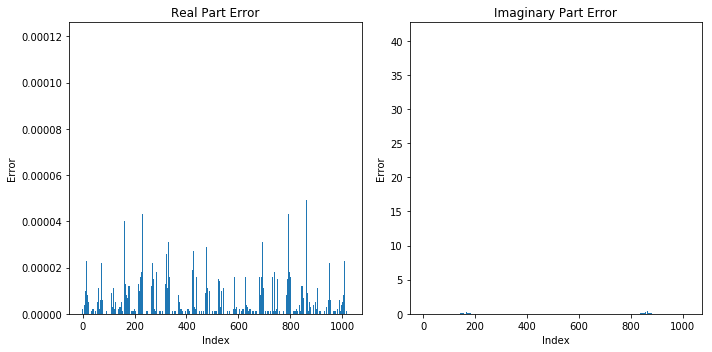

In [68]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,real_error)
plt.title("Real Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,imag_error)
plt.title("Imaginary Part Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

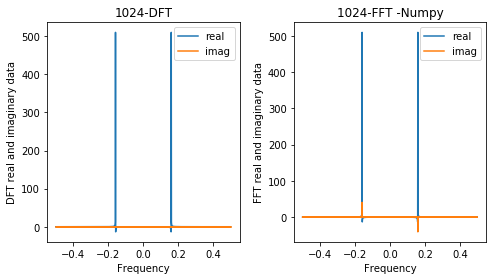

In [69]:
freq=np.fft.fftfreq(1024)

plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(freq,out_r,label='real')
plt.plot(freq,out_i,label='imag')
plt.title("1024-DFT")
plt.xlabel("Frequency")
plt.ylabel("DFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(freq,golden_op.real,label='real')
plt.plot(freq,golden_op.imag,label='imag')
plt.title("1024-FFT -Numpy")
plt.xlabel("Frequency")
plt.ylabel("FFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.show()